In [1]:
using Images

GROUND_TRUTH_FOLDER = "/Users/manvithaponnapati/RAISR/train_data/ground_truth/"
LOW_RES_FOLDER = "/Users/manvithaponnapati/RAISR/train_data/low_res/"
INTERPOLATED_FOLDER = "/Users/manvithaponnapati/RAISR/train_data/interpolated/"

"/Users/manvithaponnapati/RAISR/train_data/interpolated/"

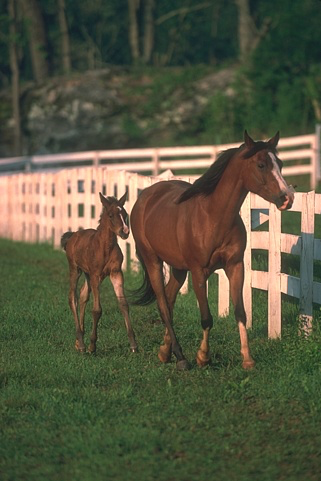

In [2]:
#High Resolution Image
high_res_im = load(GROUND_TRUTH_FOLDER*"113009.jpg")

In [3]:
w,h = size(high_res_im)
println("Image dimensions $w and $h")

Image dimensions 481 and 321


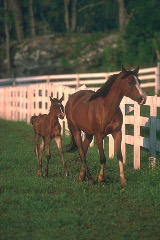

In [4]:
scale_factor = 2
scaled_dow_im = load(LOW_RES_FOLDER*"113009.jpg")
low_res_im = load(INTERPOLATED_FOLDER*"113009.jpg")
scaled_dow_im

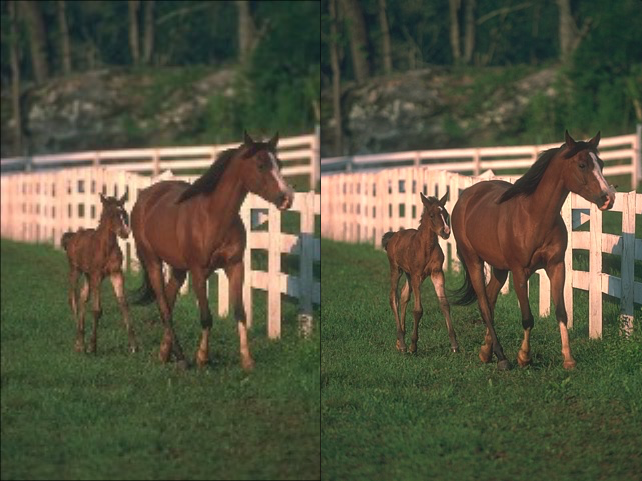

In [5]:
[low_res_im high_res_im]

In [6]:
Pkg.add("Distributions")

INFO: Package Distributions is already installed
INFO: METADATA is out-of-date — you may not have the latest version of Distributions
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [20]:
using Distributions
#Calculate image properties
#Taking 3x3 patches on the imahes 
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 3
Q = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize))
mark = zeros((Qstrength*Qcoherence, Qangle, scale_factor*scale_factor))

start_index = Int(ceil(patchsize/2))
weights_matrix = rand(Normal(0, 2), patchsize*patchsize)
weights_matrix = Array(Diagonal(weights_matrix))
#the really really twosted conversions on JuliaImages
colorview_rgb = convert(Array{Float64},channelview(low_res_im))
color_ve = 0.21*colorview_rgb[1,:,:]+ 0.72*colorview_rgb[2,:,:]+0.07*colorview_rgb[3,:,:]
w,h = size(color_ve)
for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
        patch = color_ve[row-1:row+1,col-1:col+1]
        gx,gy = imgradients(patch)
        gx = reshape(gx,patchsize*patchsize,1)
        gy = reshape(gy,patchsize*patchsize,1)
        GT = transpose([gx gy])
        GTWG = GT*weights_matrix*transpose(GT)
        eigen_max = eigmax(GTWG)
        eigen_min = eigmin(GTWG)
        eigen_vector_max = eigvecs(GTWG)[:,1]
        eigen_vector_min = eigvecs(GTWG)[:,2]
        gradient_angle = atan2(eigen_vector_max[2],eigen_vector_max[1])
        if gradient_angle < 0
            gradient_angle = gradient_angle + pi
        end
        lamda = abs(sqrt(complex(eigen_max)))/Qstrength
        u =(sqrt(complex(eigen_max)) -  sqrt(complex(eigen_min)))/(sqrt(complex(eigen_max)) +  sqrt(complex(eigen_min)))/Qcoherence
        angle = floor(gradient_angle/pi*Qangle)
      
        
        if lamda < 0.0001
            strength = 1
        elseif lamda > 0.001
            strength = 3
        else
            strength = 2
        end
           
        u = abs(u)
        if u < 0.25
            coherence = 1
        elseif u > 0.5
            coherence = 3
        else
            coherence = 2
        end
        
        
        # Bound the output to the desired ranges
        if angle > 23
            angle = 23
        elseif angle <= 0
            angle = 1
        end
        angle = Int(angle)
        # Get pixel type
        pixeltype = ((row-start_index) % scale_factor) * scale_factor + ((col-start_index) % scale_factor)
        pixelHR = color_ve[row,col]
        # Compute A'A and A'b
        wp,hp = size(patch)
        patch_1 = reshape(patch,wp*hp,1)
        patch = reshape(patch,wp*hp)
        ATA = dot(transpose(patch_1),patch_1)
        ATb = patch*pixelHR
        Q[angle,strength,coherence,pixeltype+1,:,:] += ATA
        V[angle,strength,coherence,pixeltype+1,:] += ATb
        mark[coherence*3+strength, angle, pixeltype] += 1
    end
end


A,S,C 23, 3, 1, 0
(9,)
(9,)


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] imgradients(::Array{Float64,2}) at /Users/manvithaponnapati/.julia/v0.6/ImageFiltering/src/specialty.jl:50
 [3] macro expansion at ./In[20]:21 [inlined]
 [4] anonymous at ./<missing>:?
 [5] include_string(::String, ::String) at ./loading.jl:515
 [6] include_string(::Module, ::String, ::String) at /Users/manvithaponnapati/.julia/v0.6/Compat/src/Compat.jl:478
 [7] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/execute_request.jl:154
 [8] eventloop(::ZMQ.Socket) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[20], in expression starting on line 18


A,S,C 9, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 8, 3, 2, 1
(9,)
(9,)
A,S,C 13, 3, 2, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 10, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 2, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 13, 3, 2, 1
(9,)
(9,)
A,S,C 13, 3, 2, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 11, 3, 2, 0
(9,)
(9,)
A,S,C 11, 3, 2, 1
(9,)
(9,)
A,S,C 10, 3, 2, 0
(9,)
(9,)
A,S,C 10, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 11, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 11, 3, 2, 1
(9,)
(9,)
A,S,C 10, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 10, 3, 2, 0
(9,)
(9,)
A,S,C 10, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A

A,S,C 8, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 2, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 14, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 13, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 12, 3, 2, 2
(9,)
(9,)
A,S,C 12, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 7, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 15, 3, 2, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 

(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 7, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 7, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 8, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 2, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 6, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S

A,S,C 12, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 2, 3
(9,)
(9,)
A,S,C 17, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 12, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 16, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 12, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 15, 3, 2, 2
(9,)
(9,)
A,S,C 5, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 14, 3, 1, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 1

(9,)
A,S,C 9, 3, 1, 1
(9,)
(9,)
A,S,C 6, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 10, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 2, 0
(9,)
(9,)
A,S,C 16, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 13, 3, 1, 0
(9,)
(9,)
A,S,C 11, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 2, 0
(9,)
(9,)
A,S,C 20, 3, 2, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 2, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 6, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 2, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 14, 3, 1, 0
(9,)
(9,)
A,S,C 9, 3, 2, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 9, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A

A,S,C 8, 3, 2, 3
(9,)
(9,)
A,S,C 9, 3, 1, 2
(9,)
(9,)
A,S,C 9, 3, 1, 3
(9,)
(9,)
A,S,C 9, 3, 1, 2
(9,)
(9,)
A,S,C 10, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 2, 2
(9,)
(9,)
A,S,C 14, 3, 1, 3
(9,)
(9,)
A,S,C 15, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 16, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 9, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 8, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 11, 3, 2, 2
(9,)
(9,)
A,S,C 12, 3, 2, 3
(9,)
(9,)
A,S,C 15, 3, 2, 2
(9,)
(9,)
A,S,C 14, 3, 1, 3
(9,)
(9,)
A,S,C 16, 3, 2, 2
(9,)
(9,)
A,S,C 15, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 18, 3, 2, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 6, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3,

A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 8, 3, 1, 0
(9,)
(9,)
A,S,C 6, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 11, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 12, 3, 1, 0
(9,)
(9,)
A,S,C 11, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 16, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 6, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 8, 3, 2, 0
(9,)
(9,)
A,S,C 5, 3, 2, 1
(9,)
(9,)
A,S,C 5, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1

A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 2, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 16, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 15, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 17, 3, 1

A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 13, 3, 2, 2
(9,)
(9,)
A,S,C 12, 3, 2, 3
(9,)
(9,)
A,S,C 12, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 6, 3, 2, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 16, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 2, 2, 3
(9,)
(9,)
A,S,C 1, 2, 1, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 12, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 7, 3, 1, 2
(9,)
(9,)
A,S,C 8, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 6, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 

(9,)
(9,)
A,S,C 20, 3, 2, 1
(9,)
(9,)
A,S,C 7, 3, 1, 0
(9,)
(9,)
A,S,C 8, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 1, 0
(9,)
(9,)
A,S,C 10, 3, 2, 1
(9,)
(9,)
A,S,C 9, 3, 1, 0
(9,)
(9,)
A,S,C 8, 3, 2, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 3, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 2, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)


(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 15, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 2, 2
(9,)
(9,)
A,S,C 4, 3, 2, 3
(

(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 12, 3, 1, 0
(9,)
(9,)
A,S,C 9, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 11, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 16, 3, 2, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 17, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 1, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 17, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 2, 0
(9,)
(9,)
A,S,C 9, 3, 2, 1
(9,)
(9,)
A,S,C 7, 3, 1, 0
(9,)
(9,)
A,S,C 7, 3, 1, 1
(9,)
(9,)
A,S,C 9, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 16, 3, 2, 0
(9,)
(9,)
A,S,C 16, 3, 1, 1
(9,)
(9,

(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 6, 3, 1, 3
(9,)
(9,)
A,S,C 7, 3, 1, 2
(9,)
(9,)
A,S,C 6, 3, 2, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 2, 3
(9,)
(9,)
A,S,C 14, 3, 1, 2
(9,)
(9,)
A,S,C 17, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 

A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 15, 3, 1, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 2, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 1, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 15, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 7, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 12, 3, 2, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 17, 3, 1, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 8, 3, 1, 0
(9,)
(9,)
A,S,C 9, 3, 1, 1
(9,)
(9,)
A,S,C 10

A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 2, 1
(9,)
(9,)
A,S,C 15, 3, 1, 0
(9,)
(9,)
A,S,C 15, 3, 1, 1
(9,)
(9,)
A,S,C 7, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 6, 3, 1, 1
(9,)
(9,)
A,S,C 8, 3, 1, 0
(9,)
(9,)
A,S,C 11, 3, 2, 1
(9,)
(9,)
A,S,C 8, 3, 2, 0
(9,)
(9,)
A,S,C 7, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1


A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 14, 3, 1, 3
(9,)
(9,)
A,S,C 6, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 

A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 6, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 9, 3, 1, 0
(9,)
(9,)
A,S,C 9, 3, 2, 1
(9,)
(9,)
A,S,C 5, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 5, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 18, 2, 2, 1
(9,)
(9,)
A,S,C 1, 3,

A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 15, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 12, 3, 2, 2
(9,)
(9,)
A,S,C 16, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 7, 3, 2, 2
(9,)
(9,)
A,S,C 1, 2, 2, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 11, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 2, 2
(9,)
(9,)


A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 16, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3,

A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 18, 3, 1, 0
(9,)
(9,)
A,S,C 15, 3, 1, 1
(9,)
(9,)
A,S,C 8, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 15, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 6,

(9,)
(9,)
A,S,C 17, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 14, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 6, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 17, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 8, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 15, 3, 1, 3
(9,)
(9,)
A,S,C 16, 3, 2, 2
(9,)
(9,)
A,S,C 16, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)

A,S,C 13, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 1, 1
(9,)
(9,)
A,S,C 16, 3, 2, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 2, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 7, 3, 2, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3

A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 12, 3, 2, 3
(9,)
(9,)
A,S,C 15, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 14, 3, 2, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 16, 3, 2, 3
(9,)
(9,)
A,S,C 19, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 10, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 8, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 6, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 15, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 14, 3, 2, 2
(9,)
(9,)
A,

A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 1, 2, 1, 0
(9,)
(9,)
A,S,C 22, 2, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 10, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 23, 2, 1, 0
(9,)
(9,)
A,S,C 7, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 

(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 9, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 6, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 1, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 15, 3, 

A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 9, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 13, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 6, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 14, 3, 2, 2
(9,)
(9,)
A,S,C 12, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 9, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 

A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 2, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 10, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 1, 1
(9,)
(9,)
A,S,C 16, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 13, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 16, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)


A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 5, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 8, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 15, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 

A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 16, 3, 2, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 2, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 1, 0
(9,)
(9,)
A,S,C 11, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 8, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 2

(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 11, 3, 1, 3
(9,)
(9,)
A,S,C 16, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 17, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 14, 3, 1, 2
(9,)
(9,)
A,S,C 9, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 8, 3, 1, 3
(9,)
(9,)
A,S,C 9, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 11, 3, 2, 3
(9,)
(9,)
A,S,C 12, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 6, 3, 2, 2
(9,)
(9,)
A,S,C 12, 3, 1, 3
(9,)
(9,)
A,S,C 13, 3, 2, 2
(9,)
(9,)
A,S,C 14, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 6, 3, 2, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,

(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 15, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 2, 0
(9,)
(9,)
A,S,C 8, 3, 1, 1
(9,)
(9,)
A,S,C 9, 3, 1, 0
(9,)
(9,)
A,S,C 8, 3, 2, 1
(9,)
(9,)
A,S,C 8, 3, 1, 0
(9,)
(9,)
A,S,C 10, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 14, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 10, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 2, 2
(9,)
(9,

A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 6, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 17, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 7, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 6, 3, 2, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2,

(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 15, 3, 1, 2
(9,)
(9,)
A,S,C 6, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 18, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 3, 2, 2, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 11, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 2, 2
(9,)
(9,)
A,S,C

(9,)
(9,)
A,S,C 6, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 14, 3, 2, 1
(9,)
(9,)
A,S,C 11, 3, 2, 0
(9,)
(9,)
A,S,C 17, 3, 2, 1
(9,)
(9,)
A,S,C 20, 3, 2, 0
(9,)
(9,)
A,S,C 14, 3, 1, 1
(9,)
(9,)
A,S,C 11, 3, 1, 0
(9,)
(9,)
A,S,C 9, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 16, 3, 1, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 10, 3, 1, 1
(9,)
(9,)
A,S,C 14, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,

A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 12, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 14, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 18, 3, 2, 2
(9,)
(9,)
A,S,C 1, 2, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 11, 3, 2, 2
(9,)
(9,)
A,S,C 12, 3, 2, 3
(9,)
(9,)
A,S,C 15, 3, 2, 2
(9,)
(9,)
A,S,C 18, 3, 2, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 2, 2
(9,)
(9,)
A,S,C 9, 3, 2, 3
(9,)
(9,)
A,S,C 9, 3, 2, 2
(9,)
(9,)
A,S,C 10, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 12, 3, 1, 3
(9,)
(9,)
A,S,C 14, 3, 2, 2
(9,)
(9,)
A,S,C 13, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 9, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 2, 0
(9,)
(9,)
A,S,C

A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 13, 3, 2, 2
(9,)
(9,)
A,S,C 15, 3, 2, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 17, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2

A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 6, 3, 1, 1
(9,)
(9,)
A,S,C 16, 3, 1, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 7, 3, 2, 0
(9,)
(9,)
A,S,C 5, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 2, 0
(9,)
(9,)
A,S,C 20, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S

A,S,C 9, 3, 2, 2
(9,)
(9,)
A,S,C 5, 3, 2, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 12, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 16, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 15, 3, 1, 3
(9,)
(9,)
A,S,C 13, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 12, 3, 2, 2
(9,)
(9,)
A,S,C 12, 3, 2, 3
(9,)
(9,)
A,S,C 17, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 6, 3, 1, 3
(9,)
(9,)
A,S,C 6, 3, 1, 2
(9,)
(9,)
A,S,C 11, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C

A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 2, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 10, 3, 2, 3
(9,)
(9,)
A,S,C 20, 3, 2, 2
(9,)
(9,)
A,S,C 6, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 17, 3, 2, 3
(9,)
(9,)
A,S,C 14, 3, 1, 2
(9,)
(9,)
A,S,C 8, 3, 2, 

A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 21, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 22, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 1, 1
(9,)
(9,)
A,S,C 9, 3, 2, 0
(9,)
(9,)
A,S,C 17, 3, 2, 1
(9,)
(9,)
A,S,C 18, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 

(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 18, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 2, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 17, 3, 1, 2
(9,)
(9,)
A,S,C 17, 3, 2, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 2, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 8, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,

A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 20, 3, 2, 1
(9,)
(9,)
A,S,C 9, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 11, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 11, 3, 2, 0
(9,)
(9,)
A,S,C 16, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 1, 0
(9,)
(9,)
A,S,C 16, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 16, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 2, 0
(9,)
(9,)
A,S,C 20, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 12, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 8, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C

(9,)
(9,)
A,S,C 15, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 4, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 11, 3, 1, 0
(9,)
(9,)
A,S,C 9, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 18, 3, 1, 1
(9,)
(9,)
A,S,C 14, 3, 2, 0
(9,)
(9,)
A,S,C 17, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 5, 3, 2, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 22, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,

A,S,C 4, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 15, 3, 2, 2
(9,)
(9,)
A,S,C 15, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 7, 3, 2, 3
(9,)
(9,)
A,S,C 8, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 2, 3
(9,)
(9,)
A,S,C 15, 3, 1, 2
(9,)
(9,)
A,S,C 15, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 2, 2
(9,)
(9,)
A,S,C 7, 3, 1, 3
(9,)
(9,)
A,S,C 12, 3, 1, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 7, 3, 1, 3
(9,)
(9,)
A,S,C 19, 

(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 1, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 12, 3, 2, 0
(9,)
(9,)
A,S,C 12, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 9, 3, 1, 1
(9,)
(9,)
A,S,C 6, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 18, 3, 2, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 10, 3, 1, 1
(9,)
(9,)
A,S,C 10, 3, 1, 0
(9,)
(9,)
A,S,C 14, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 1, 1
(9,)
(9,)
A,S,C 5, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)

A,S,C 4, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 10, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 10, 3, 1, 3
(9,)
(9,)
A,S,C 16, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 5, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 2, 3
(9,)
(9,)
A,S,C 1, 2, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 16, 3, 1

(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 19, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 20, 3, 1, 2
(9,)
(9,)
A,S,C 4, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 15, 3, 1, 2
(9,)
(9,)
A,S,C 16, 3, 1, 3
(9,)
(9,)
A,S,C 16, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 18, 3, 1, 2
(9,)
(9,)
A,S,C 18, 3, 2, 3
(9,)
(9,)
A,S,C 15, 3, 1, 2
(9,)
(9,)
A,S,C 13, 3, 2, 3
(9,)
(9,)
A,S,C 5, 3, 2, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2


(9,)
A,S,C 3, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 1, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 6, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 2, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 2, 1
(9,)
(9,)
A,S,C 22, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 16, 3, 1, 0
(9,)
(9,)
A,S,C 19, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 20, 3, 1, 0
(9,)
(9,)
A,S,C 4, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 1, 0
(9,)
(9,)
A,S,C 3, 3, 1, 1
(9,)
(9,)
A,S,C 2, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 1, 1
(9,)
(9,)
A,S,C 15, 3, 1, 0
(9,)
(9,)
A,S,C 1, 3, 1, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 2, 3, 2, 1
(9,)
(9,)
A,S,C 3, 3, 2, 0
(9,)
(9,)
A,S,C 1, 3, 2, 1
(9,)
(9,)
A,S,C 23, 3, 2, 0
(9,)
(9,)
A,S,C 23, 3, 1, 1
(9,)
(9,)
A,S,C 21, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 2, 1
(9,)
(9,)
A,S,C 19, 3, 1, 0
(9,)
(9,)
A,S,C 21, 3, 1, 1
(9,)
(9,)
A,S,C 23, 3, 1, 0
(9,)
(9,)
A,S,C

A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 1, 2
(9,)
(9,)
A,S,C 11, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 20, 3, 1, 3
(9,)
(9,)
A,S,C 17, 3, 2, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 20, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 17, 3, 1, 2
(9,)
(9,)
A,S,C 12, 3, 1, 3
(9,)
(9,)
A,S,C 5, 3, 2, 2
(9,)
(9,)
A,S,C 6, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 16, 3, 1, 2
(9,)
(9,)
A,S,C 22, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 9, 3, 1, 2
(9,)
(9,)
A,S,C 8, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 2, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 1, 2
(9,)
(9,)
A,S,C 17, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 20,

A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 1, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 2, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3, 2, 3
(9,)
(9,)
A,S,C 1, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)
A,S,C 2, 3, 1, 3
(9,)
(9,)
A,S,C 3, 3, 1, 2
(9,)
(9,)
A,S,C 3, 3, 1, 3
(9,)
(9,)
A,S,C 19, 3, 1, 2
(9,)
(9,)
A,S,C 21, 3, 1, 3
(9,)
(9,)
A,S,C 22, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 21, 3, 2, 2
(9,)
(9,)
A,S,C 21, 3, 2, 3
(9,)
(9,)
A,S,C 4, 3, 1, 2
(9,)
(9,)
A,S,C 14, 3, 1, 3
(9,)
(9,)
A,S,C 17, 3, 2, 2
(9,)
(9,)
A,S,C 19, 3, 2, 3
(9,)
(9,)
A,S,C 20, 3, 2, 2
(9,)
(9,)
A,S,C 1, 3, 1, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 22, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 2, 2
(9,)
(9,)
A,S,C 23, 3, 2, 3
(9,)
(9,)
A,S,C 23, 3, 1, 2
(9,)
(9,)
A,S,C 1, 3

Excessive output truncated after 524304 bytes.

A,S,C 15, 3, 2, 2
(9,)
(9,)
A,S,C 16, 3, 2, 3
(9,)
(9,)
A,S,C 17, 3, 2, 2
(9,)
(9,)
A,S,C 18, 3, 1, 3
(9,)
(9,)
A,S,C 1, 3, 1, 2
(9,)
(9,)


In [39]:
println("Calculating filterS")
# Conjugate Gradients Solver
function cgls(A, b)
   
    height, width = size(A)
    
    x = zeros((height))
    while(true)
        sumA = sum(A)
        
        if (sumA < 100)
            break
        end
        if (det(A) < 1)
            A = A + eye(height, width) * sumA * 0.000000005
        else
            x = inv(A)*b
            break
        end
    end
    println("Return $x")
    return x
end

h = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize))
operationcount = 0
totaloperations = scale_factor * scale_factor * Qangle * Qstrength * Qcoherence
for pixeltype in range(1, scale_factor*scale_factor)
    for angle in range(1, Qangle)
        for strength in range(1, Qstrength)
            for coherence in range(1, Qcoherence)
                println("index $pixeltype,$angle, $strength, $coherence")
                operationcount += 1
                h[angle,strength,coherence,pixeltype,:] = cgls(Q[angle,strength,coherence,pixeltype,:,:], V[angle,strength,coherence,pixeltype,:])
            end
        end
    end
end

Calculating filterS
index 1,1, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,1, 1, 2
()
Return [0.0117393, 0.0117393, 0.0117393, 0.0117393, 0.0117393, 0.0117393, 0.0117393, 0.0117393, 0.0117393]
index 1,1, 1, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,1, 2, 1
()
Return [0.00835132, 0.00835132, 0.00990142, 0.0148334, 0.0139965, 0.0126377, 0.0134379, 0.0134379, 0.0141268]
index 1,1, 2, 2
()
Return [0.00891631, 0.0133591, 0.0137636, 0.0115065, 0.0122505, 0.0134863, 0.0117957, 0.0120843, 0.0113945]
index 1,1, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,1, 3, 1
()
Return [-14.0498, -10.6541, -20.8119, 13.3954, 18.9228, 4.43764, 5.947, 7.77941, -4.8552]
index 1,1, 3, 2
()
Return [-58.8229, -32.6746, -45.9355, 25.4891, 51.6381, 35.8671, -3.81597, 20.7977, 7.56821]
index 1,1, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,2, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,2, 1, 2
(

Return [-0.635931, 0.24992, 0.705351, -0.95001, -0.00558081, 0.261908, -0.370725, 0.502731, 0.3528]
index 1,16, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,17, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,17, 1, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,17, 1, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,17, 2, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,17, 2, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,17, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,17, 3, 1
()
Return [0.903896, 0.756998, -0.428661, 0.603019, 0.761733, -0.613433, 0.286292, -0.21714, -1.94177]
index 1,17, 3, 2
()
Return [0.184586, 0.432013, -0.192944, 0.923824, 0.811861, -0.557988, 0.00561675, -0.329966, -1.16554]
index 1,17, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 1,18, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Return [0.0108051, 0.0117296, 0.0163719, 0.0114305, 0.0123549, 0.0113163, 0.0114305, 0.0114305, 0.0113163]
index 2,4, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,4, 3, 1
()
Return [-2.01873, -0.873422, -1.47637, 0.439245, 0.723172, -0.234891, 1.60989, 1.38939, 0.552422]
index 2,4, 3, 2
()
Return [0.653199, -0.585918, -2.53928, 1.13126, 0.301791, -1.09429, 1.27448, 0.815693, 0.153936]
index 2,4, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,5, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,5, 1, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,5, 1, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,5, 2, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,5, 2, 2
()
Return [0.0126446, 0.0113235, 0.0115319, 0.012525, 0.0112039, 0.0112294, 0.012525, 0.0119956, 0.0112294]
index 2,5, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,5, 3, 1
()
Return [2.025

Return [-0.155384, 2.03881, 0.242618, 0.648454, 1.92242, -1.7131, 0.923201, 0.895194, -4.69088]
index 2,15, 3, 2
()
Return [-0.741603, -0.0583348, 0.0857458, -0.331456, 0.440539, 0.175869, -0.191046, 0.508764, 0.222961]
index 2,15, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,16, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,16, 1, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,16, 1, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,16, 2, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,16, 2, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,16, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 2,16, 3, 1
()
Return [0.124241, 1.03104, -0.253787, 0.275769, 0.926171, -0.931089, -0.131449, 0.562355, -1.49229]
index 2,16, 3, 2
()
Return [0.558461, 0.105145, -0.0627203, 0.409487, -0.0631118, -0.277613, 0.10892, -0.295849, -0.372483]
index 2,16, 3, 3
()
Retur

Return [0.0127836, 0.0122145, 0.0120618, 0.0108671, 0.0100257, 0.0107226, 0.0117115, 0.0111891, 0.012123]
index 3,5, 2, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,5, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,5, 3, 1
()
Return [1.76125, -0.613037, -2.87808, 3.62753, 0.757384, -2.44045, 2.1794, 0.0503322, -2.33369]
index 3,5, 3, 2
()
Return [0.389623, -0.702326, -2.14418, 1.18602, 0.356995, -0.605218, 0.967756, 0.593343, 0.0685805]
index 3,5, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,6, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,6, 1, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,6, 1, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,6, 2, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,6, 2, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,6, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,6, 3

Return [0.890839, 0.16597, -0.83787, 1.62977, 1.00298, -0.0649013, 0.66961, -0.791516, -2.55382]
index 3,17, 3, 2
()
Return [1.4872, -0.0984106, -1.476, 2.61075, 1.03214, -0.938948, 0.460859, -0.82097, -2.14546]
index 3,17, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,18, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,18, 1, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,18, 1, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,18, 2, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,18, 2, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,18, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 3,18, 3, 1
()
Return [-1.60278, -0.692953, 0.176206, 1.59081, 2.19055, 1.68635, 1.39187, -0.902172, -3.72692]
index 3,18, 3, 2
()
Return [0.447621, 0.201905, -0.237642, 0.523467, 0.514296, -0.0883675, -0.180838, -0.314841, -0.754965]
index 3,18, 3, 3
()
Return [0.0, 0.0,

Return [0.011539, 0.011539, 0.0122221, 0.011539, 0.011539, 0.011539, 0.011539, 0.011539, 0.011539]
index 4,4, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,4, 3, 1
()
Return [0.632644, -0.0647521, -0.775389, 1.26597, 0.678176, -0.723184, 0.332552, 0.0186221, -1.25415]
index 4,4, 3, 2
()
Return [1.16791, -0.426036, -1.86017, 1.45038, 0.00760949, -1.2187, 1.02432, 0.371073, -0.405715]
index 4,4, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,5, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,5, 1, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,5, 1, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,5, 2, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,5, 2, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,5, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,5, 3, 1
()
Return [3.51085, 2.79667, 1.54876, 0.327278, 0.45802, -0.172614, -3.

Return [0.0124123, 0.0100494, 0.0135016, 0.0119631, 0.012823, 0.0112302, 0.0146453, 0.0141641, 0.00956613]
index 4,18, 2, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,18, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,18, 3, 1
()
Return [3.27477, 2.71064, 1.81462, 1.78145, 0.138248, -1.53221, -0.676106, -2.74291, -4.65796]
index 4,18, 3, 2
()
Return [0.183899, 0.398435, 0.141257, 0.0685495, -0.123169, -0.00173497, -0.164623, -0.37222, -0.0197105]
index 4,18, 3, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,19, 1, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,19, 1, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,19, 1, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,19, 2, 1
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,19, 2, 2
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index 4,19, 2, 3
()
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [43]:
using JLD
save("filterslearned.jld", "filters", h)

INFO: Installing JLD v0.8.3
INFO: Installing LegacyStrings v0.2.2
INFO: Building Homebrew
Error: git: /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Library/Taps/homebrew/homebrew-core/Formula/git.rb:190: syntax error, unexpected $undefined, expecting keyword_end
      \thelper = osxkeychain
       ^
==============================[ ERROR: Homebrew ]===============================

LoadError: ArgumentError: `brew info` failed for String["git"]!
while loading /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/build.jl, in expression starting on line 2

INFO: Building Blosc
INFO: Building HDF5
Error: hdf5: /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Library/Taps/homebrew/homebrew-core/Formula/hdf5.rb:71: syntax error, unexpected ';', expecting =>
/Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Library/Taps/homebrew/homebrew-core/Formula/hdf5.rb:73: syntax error, unexpected '}', expecting keyword_end
/Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Library/T


================================[ BUILD ERRORS ]================================


 - packages with build errors remain installed in /Users/manvithaponnapati/.julia/v0.6
 - build the package(s) and all dependencies with `Pkg.build("Homebrew")`
 - build a single package by running its `deps/build.jl` script

INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of JLD
INFO: Use `Pkg.update()` to get the latest versions of your packages
